### Steps:

0.1 download sparse mouse single-cell data from https://www.ebi.ac.uk/arrayexpress/experiments/E-MTAB-6967/

0.2 Read and Operate the large sparse matrix on the cluster

1. down sample to N reads per cell (keep $\ge 90\%$ or $100,000$ reads/cell)


2. Gene Filter. throw out genes ($\mu < 0.05 x(M)$ and $\sigma < 0.05$)


3. $\log_2(1+X)$


4. z-score normalize


### 0. read the data and print some necessary info

In [2]:
from scipy.io import mmread,mminfo

# the info of the matrix
info = mminfo(r'atlas/raw_counts.mtx')
print(info)
print(info[2]/(info[0]*info[1]))

# read in the matrix
data = mmread(r'atlas/raw_counts.mtx')

# memory status
info = psutil.virtual_memory()
print(info.total)
print(info.percent)

(29452, 139331, 483512215, 'coordinate', 'integer', 'general')
0.11782702279423168
202262147072
28.9


So the origin matrix has dimension $[29452,139331]$, where only $483512215$ entries are nonzeros, $11.78\%$. 

And the encoding form of the matrix is 'coordinate'. And all the entries are integers, which is natural because they are all counts.  

The matrix read takes long long time.

In [3]:
import scipy as sp

# the gene info 
geneinfo = sp.genfromtxt(r'atlas/genes.tsv',dtype=str)
print(geneinfo.shape)
print(geneinfo[10:15,:])

(29452, 2)
[['ENSMUSG00000002459' 'Rgs20']
 ['ENSMUSG00000085623' 'Gm16041']
 ['ENSMUSG00000033793' 'Atp6v1h']
 ['ENSMUSG00000025905' 'Oprk1']
 ['ENSMUSG00000033774' 'Npbwr1']]


In [7]:
# the meta data
import pandas as pd
metadata = pd.read_csv(r'atlas/meta.csv',index_col=0,header=0,low_memory=False)

In [8]:
print(metadata.shape)
print(metadata.columns[0:5])
print(metadata.barcode[0])

# memory status
info = psutil.virtual_memory()
print(info.total)
print(info.percent)

metadata.head(n=2)

(139331, 27)
Index(['barcode', 'sample', 'stage', 'sequencing.batch', 'theiler'], dtype='object')
AAAGGCCTCCACAA
202262147072
27.3


,barcode,sample,stage,sequencing.batch,theiler,doub.density,doublet,cluster,cluster.sub,cluster.stage,...,haem_gephiY,haem_subclust,endo_gephiX,endo_gephiY,endo_trajectoryName,endo_trajectoryDPT,endo_gutX,endo_gutY,endo_gutDPT,endo_gutCluster
cell,,,,,,,,,,,,,,,,,,,,,
cell_1,AAAGGCCTCCACAA,1,E6.5,1,TS9,0.043114,False,2.0,4.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_2,AACAAACTCGCCTT,1,E6.5,1,TS9,1.129713,False,12.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The above two data give some details information about the cells and genes.

### 0.1. Operating the large sparse matrix 'data'

The sparse matrix is already read and stored in the sparse matrix variable 'data', using COOrdinate format, $483512215$ elements.

Change the COO sparse matrix into CSR format, for efficient row operating. Now we can use the variable `mtx` in future processing.

In [4]:
data

<29452x139331 sparse matrix of type '<class 'numpy.int64'>'
	with 483512215 stored elements in COOrdinate format>

In [5]:
mtx = data.tocsr()

# memory status
info = psutil.virtual_memory()
print(info.total)
print(info.percent)

202262147072
32.1


In [ ]:
import numpy as np
print(mtx[0:20,0])
print('total gene counts for', metadata.index[100],'is',np.sum(mtx[:,100]))

### 1. downsample to 10000 reads per cell (keep  ≥ $90\%$  or  100,000  reads/cell)

#### 1.1 drop cells with gene < 10000

In [7]:
genect = np.sum(mtx,axis=0)
genect = np.array(genect)[0]
print(genect.shape)
w = np.where(genect > 10000)  # select cells with gene > 10000
print(np.size(w))

(139331,)
113803


In [8]:
genect = genect[w]
mtx = mtx[:,tuple(np.array(w).reshape(-1))]

# memory status
info = psutil.virtual_memory()
print(info.total)
print(info.percent)

mtx.shape

202262147072
31.6


(29452, 113803)

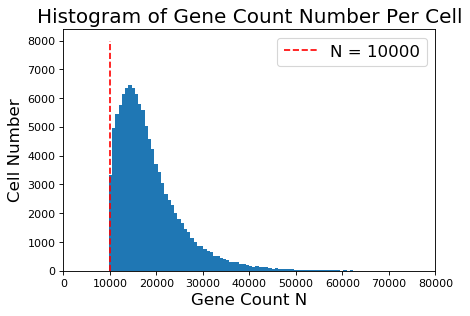

In [159]:
import matplotlib.pyplot as plt

plt.figure(dpi=80)
plt.title('Histogram of Gene Count Number Per Cell',fontsize=18)
plt.xlabel('Gene Count N',fontsize=15)
plt.ylabel('Cell Number',fontsize=15)
plt.xlim([0,80000])
plt.hist(genect,bins=100,range=(0,70000))
plt.plot([10000,10000],[0,8000],'r--',label='N = 10000')
plt.legend(fontsize=15)
plt.savefig(r'1.png',format='png')

#### 1.2  randomly sample 10,000 reads for each cell

Now we only have cells with more than $10,000$ genes. For downsampling, we randomly select $10,000$ reads for each cell. With the following codes.

In [151]:
# This is a function to downsample a numpy count array
# data is the origin numpy array for downsampling; sum(data) = N
# M is the target counts for downsample, we want sum(res)=M
def downsample1(data,M,batch0=50000):
    
    res = data.copy()
    N = np.shape(res)[0]
    
    while res.sum()>M:
        weights = res/res.sum()
        batch = np.min([batch0,res.sum()-M])
        c = np.random.choice(np.arange(N),size=batch,p=weights.toarray().reshape(-1))
        res[c] -= (res[c]>0).astype(np.int)
        res[res<0]=0
    return(res)

def downsample2(data,M,dim=29452):
    
    res = np.zeros(dim)
    
    temp = data.copy().toarray()
    
    weights = temp/temp.sum()
    
    c = np.random.choice(np.arange(dim),size=M,p=weights.reshape(-1))
    
    for i in c:
        res[i] += 1
    
    return(np.transpose(sp.sparse.csr_matrix(res)))


from tqdm import tqdm
M = 10000 # target summation

# downsample the whole sparse matrix
for i in tqdm(range(mtx.shape[1])):
    mtx[:,i] = downsample2(mtx[:,i],M)

sp.io.mmwrite(r'/n/home06/minhuan/test/Multi_Model_Mapping/2.mtx',mtx1,field='integer')

The above cell takes about 24 Hours, so i submit to the cluster as a job. The following steps starts in the next file.